# Converting h5 files to df and combined df and Analysis 

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import scanpy as sc
import os

# Define directory containing .h5 files
data_dir = "/Users/mominaahsan/Desktop/Cell bio project/"
h5_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])
print("🗂 Found files:\n", h5_files)

🗂 Found files:
 ['GSM4339769_C141_filtered_feature_bc_matrix.h5', 'GSM4339770_C142_filtered_feature_bc_matrix.h5', 'GSM4339771_C143_filtered_feature_bc_matrix.h5', 'GSM4339772_C144_filtered_feature_bc_matrix.h5', 'GSM4339773_C145_filtered_feature_bc_matrix.h5', 'GSM4339774_C146_filtered_feature_bc_matrix.h5', 'GSM4475048_C51_filtered_feature_bc_matrix.h5', 'GSM4475049_C52_filtered_feature_bc_matrix.h5', 'GSM4475050_C100_filtered_feature_bc_matrix.h5', 'GSM4475051_C148_filtered_feature_bc_matrix.h5', 'GSM4475052_C149_filtered_feature_bc_matrix.h5', 'GSM4475053_C152_filtered_feature_bc_matrix.h5']


In [3]:
# Step 1: Load and inspect individual files
sample_shapes = {}
all_adatas = []

print("\n📊 Raw Data Overview (Before Normalization)\n")
for file in h5_files:
    file_path = os.path.join(data_dir, file)

    adata = sc.read_10x_h5(file_path)
    adata.var_names_make_unique()

    # Save shape info for display
    num_cells, num_genes = adata.shape
    sample_shapes[file] = (num_cells, num_genes)
    print(f"{file}: {num_cells} cells × {num_genes} genes")

    # Add sample info to obs
    adata.obs["sample_id"] = file
    all_adatas.append(adata)



📊 Raw Data Overview (Before Normalization)

GSM4339769_C141_filtered_feature_bc_matrix.h5: 6249 cells × 33539 genes
GSM4339770_C142_filtered_feature_bc_matrix.h5: 10269 cells × 33539 genes
GSM4339771_C143_filtered_feature_bc_matrix.h5: 20857 cells × 33539 genes
GSM4339772_C144_filtered_feature_bc_matrix.h5: 3716 cells × 33539 genes
GSM4339773_C145_filtered_feature_bc_matrix.h5: 18044 cells × 33539 genes
GSM4339774_C146_filtered_feature_bc_matrix.h5: 4111 cells × 33539 genes
GSM4475048_C51_filtered_feature_bc_matrix.h5: 11115 cells × 33538 genes
GSM4475049_C52_filtered_feature_bc_matrix.h5: 10366 cells × 33538 genes
GSM4475050_C100_filtered_feature_bc_matrix.h5: 8972 cells × 33538 genes
GSM4475051_C148_filtered_feature_bc_matrix.h5: 3920 cells × 33539 genes
GSM4475052_C149_filtered_feature_bc_matrix.h5: 2879 cells × 33539 genes
GSM4475053_C152_filtered_feature_bc_matrix.h5: 7732 cells × 33539 genes


In [4]:
# Step 2: Combine all into a single AnnData
adata_combined = all_adatas[0].concatenate(
    *all_adatas[1:],
    batch_key="sample_batch",
    batch_categories=h5_files,
    index_unique=None  # Keep original cell barcodes
)
# Make sure gene names are unique across all batches
adata_combined.var_names_make_unique()

In [5]:
# Step 3: Summary of combined data
print("\n✅ Combined AnnData Summary")
print(f"Total shape: {adata_combined.shape} (cells × genes)")
print(f"Samples combined: {adata_combined.obs['sample_id'].nunique()}")
print("Sample breakdown:")
print(adata_combined.obs['sample_id'].value_counts())




✅ Combined AnnData Summary
Total shape: (108230, 33538) (cells × genes)
Samples combined: 12
Sample breakdown:
sample_id
GSM4339771_C143_filtered_feature_bc_matrix.h5    20857
GSM4339773_C145_filtered_feature_bc_matrix.h5    18044
GSM4475048_C51_filtered_feature_bc_matrix.h5     11115
GSM4475049_C52_filtered_feature_bc_matrix.h5     10366
GSM4339770_C142_filtered_feature_bc_matrix.h5    10269
GSM4475050_C100_filtered_feature_bc_matrix.h5     8972
GSM4475053_C152_filtered_feature_bc_matrix.h5     7732
GSM4339769_C141_filtered_feature_bc_matrix.h5     6249
GSM4339774_C146_filtered_feature_bc_matrix.h5     4111
GSM4475051_C148_filtered_feature_bc_matrix.h5     3920
GSM4339772_C144_filtered_feature_bc_matrix.h5     3716
GSM4475052_C149_filtered_feature_bc_matrix.h5     2879
Name: count, dtype: int64


In [6]:
# Optional: peek at gene names and obs info
print("\n🔍 First few genes:", adata_combined.var_names[:5].tolist())
print("🔍 Metadata columns:", adata_combined.obs.columns.tolist())


🔍 First few genes: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']
🔍 Metadata columns: ['sample_id', 'sample_batch']


# FILTERING 

We’ll start with basic filtering to remove:

1. Low-quality cells (with very few expressed genes)
2. Rare/noisy genes (expressed in too few cells)

In [7]:
# Save raw counts before filtering (optional)
adata_combined.raw = adata_combined.copy()

# Filter out cells with fewer than 200 genes expressed
sc.pp.filter_cells(adata_combined, min_genes=200)

# Filter out genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata_combined, min_cells=3)

# Show what remains
print(f"✅ After filtering: {adata_combined.n_obs} cells × {adata_combined.n_vars} genes")


✅ After filtering: 90695 cells × 25626 genes


# Normalization

1. Normalize total counts per cell to 10,000
2. Apply log-transformation to compress extreme values

In [8]:
# Normalize total counts per cell
sc.pp.normalize_total(adata_combined, target_sum=1e4)

# Log-transform the data (log1p = log(x + 1))
sc.pp.log1p(adata_combined)

print("✅ Normalization and log-transformation complete.")


✅ Normalization and log-transformation complete.


In [9]:
sc.pp.calculate_qc_metrics(adata_combined, inplace=True)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Genes per Cell Histogram

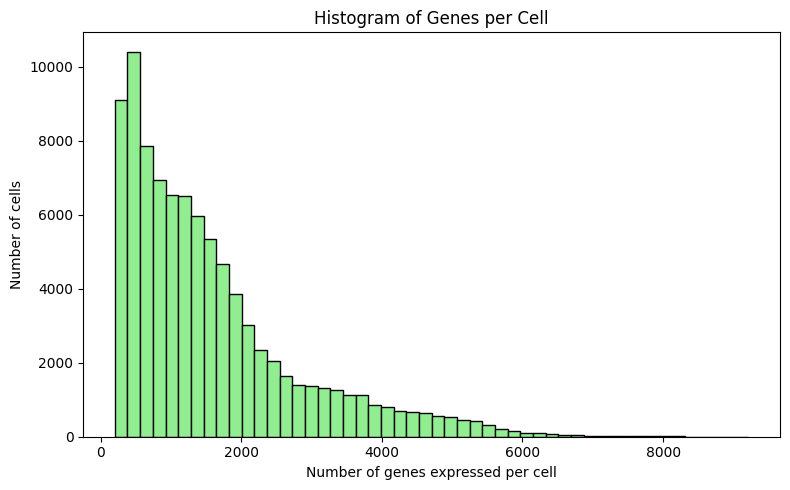

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(adata_combined.obs['n_genes_by_counts'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("Number of genes expressed per cell")
plt.ylabel("Number of cells")
plt.title("Histogram of Genes per Cell")
plt.tight_layout()
plt.show()


## UMI Counts per cell

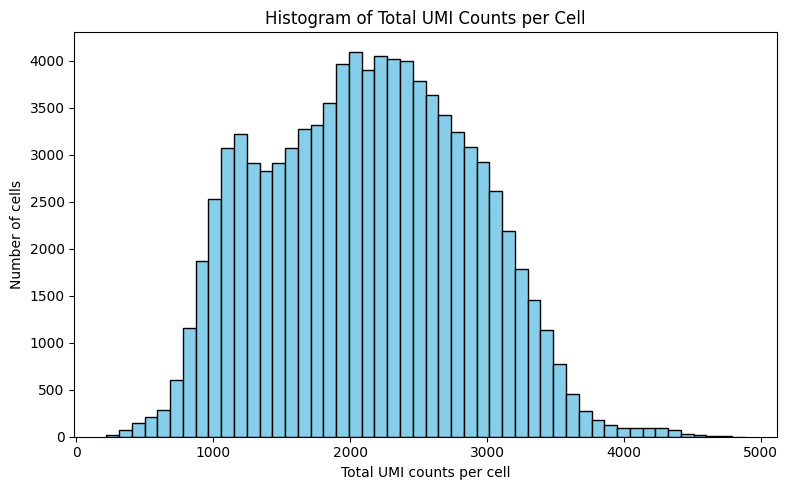

In [11]:

plt.figure(figsize=(8, 5))
plt.hist(adata_combined.obs['total_counts'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Total UMI counts per cell")
plt.ylabel("Number of cells")
plt.title("Histogram of Total UMI Counts per Cell")
plt.tight_layout()
plt.show()


## UMI Counts vs Genes per Cell

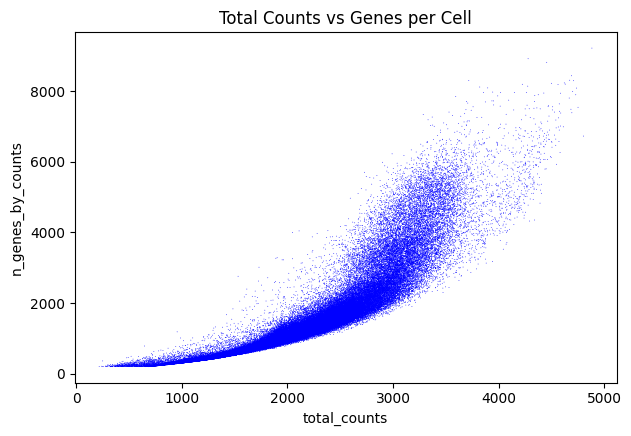

In [12]:
sc.pl.scatter(adata_combined, x='total_counts', y='n_genes_by_counts',
              color='blue', title='Total Counts vs Genes per Cell')


In [13]:
my_markers = ['TRAV38-1', 'IL17A', 'TMPRSS11E']  # Add your biomarkers

# Check if biomarkers exist BEFORE HVG selection
missing_before_hvg = [gene for gene in my_markers if gene not in adata_combined.var_names]
if missing_before_hvg:
    print("⚠️ Warning: These biomarkers were missing even before HVG selection:", missing_before_hvg)
else:
    print("✅ All biomarkers are present before HVG selection.")


✅ All biomarkers are present before HVG selection.


# HVGs Inspection 

Here we keep only Highly variable genes


In [14]:
import numpy as np
sc.pp.highly_variable_genes(
    adata_combined, 
    min_mean=0.0100,  # Lower min mean to capture more genes
    max_mean=3.5,  # Slightly higher max mean to avoid losing important genes
    min_disp=0.45  # Slightly lower min dispersion to retain more variation
)

# Print how many HVGs were selected
print(f"✅ Total HVGs selected: {adata_combined.var['highly_variable'].sum()}")



✅ Total HVGs selected: 1970


In [15]:
missing_after_hvg = [gene for gene in my_markers if gene not in adata_combined.var_names]

if missing_after_hvg:
    print("⚠️ Warning: These biomarkers are STILL missing after HVG selection:", missing_after_hvg)
else:
    print("✅ All biomarkers were naturally retained in HVG selection!")



✅ All biomarkers were naturally retained in HVG selection!


In [16]:
# Keep only HVGs (and biomarkers — already retained naturally)
adata_combined = adata_combined[:, adata_combined.var['highly_variable']].copy()

# Check updated shape
print(f"✅ New shape after subsetting HVGs: {adata_combined.shape} (cells × genes)")



✅ New shape after subsetting HVGs: (90695, 1970) (cells × genes)


# SPLITTING 

In [17]:
# Define test set filenames
test_files = [
    "GSM4475048_C51_filtered_feature_bc_matrix.h5",  # Healthy
    "GSM4339769_C141_filtered_feature_bc_matrix.h5", # Mild
    "GSM4339773_C145_filtered_feature_bc_matrix.h5"  # Severe
]

# Create train and test splits
adata_test = adata_combined[adata_combined.obs["sample_id"].isin(test_files)].copy()
adata_train = adata_combined[~adata_combined.obs["sample_id"].isin(test_files)].copy()




In [18]:
# Print summary
print(f"✅ Train set: {adata_train.n_obs} cells × {adata_train.n_vars} genes")
print(f"✅ Test set: {adata_test.n_obs} cells × {adata_test.n_vars} genes")



✅ Train set: 57954 cells × 1970 genes
✅ Test set: 32741 cells × 1970 genes


In [19]:
# Verify test samples
print("🧪 Test set sample distribution:")
print(adata_test.obs["sample_id"].value_counts())

🧪 Test set sample distribution:
sample_id
GSM4339773_C145_filtered_feature_bc_matrix.h5    17396
GSM4475048_C51_filtered_feature_bc_matrix.h5     11112
GSM4339769_C141_filtered_feature_bc_matrix.h5     4233
Name: count, dtype: int64


In [20]:
# Check sample distribution
print("Train sample breakdown:")
print(adata_train.obs["sample_id"].value_counts())

print("\nTest sample breakdown:")
print(adata_test.obs["sample_id"].value_counts())


Train sample breakdown:
sample_id
GSM4339771_C143_filtered_feature_bc_matrix.h5    20289
GSM4475049_C52_filtered_feature_bc_matrix.h5     10361
GSM4475053_C152_filtered_feature_bc_matrix.h5     6962
GSM4475050_C100_filtered_feature_bc_matrix.h5     6583
GSM4339770_C142_filtered_feature_bc_matrix.h5     4562
GSM4339774_C146_filtered_feature_bc_matrix.h5     3400
GSM4475052_C149_filtered_feature_bc_matrix.h5     2485
GSM4475051_C148_filtered_feature_bc_matrix.h5     2397
GSM4339772_C144_filtered_feature_bc_matrix.h5      915
Name: count, dtype: int64

Test sample breakdown:
sample_id
GSM4339773_C145_filtered_feature_bc_matrix.h5    17396
GSM4475048_C51_filtered_feature_bc_matrix.h5     11112
GSM4339769_C141_filtered_feature_bc_matrix.h5     4233
Name: count, dtype: int64


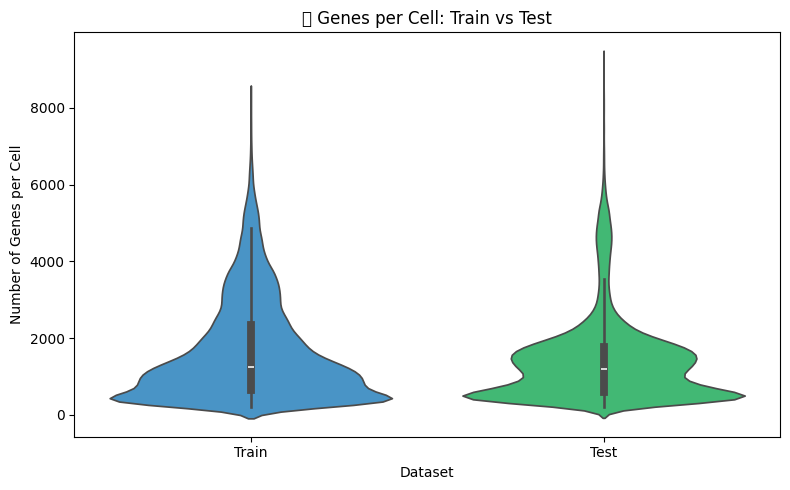

In [21]:
# Violin Plot: Genes per Cell
import pandas as pd
import seaborn as sns  # 
import matplotlib.pyplot as plt
# Ensure that train and test datasets are available
train_gene_counts = adata_train.obs['n_genes_by_counts']
test_gene_counts = adata_test.obs['n_genes_by_counts']

# Create a DataFrame for visualization
df_violin = pd.DataFrame({
    'Genes per Cell': list(train_gene_counts) + list(test_gene_counts),
    'Dataset': ['Train'] * len(train_gene_counts) + ['Test'] * len(test_gene_counts)
})

# Replot with proper grouping
plt.figure(figsize=(8,5))
sns.violinplot(x='Dataset', y='Genes per Cell', data=df_violin, palette=['#3498db', '#2ecc71'])

plt.ylabel('Number of Genes per Cell')
plt.title('🧬 Genes per Cell: Train vs Test')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

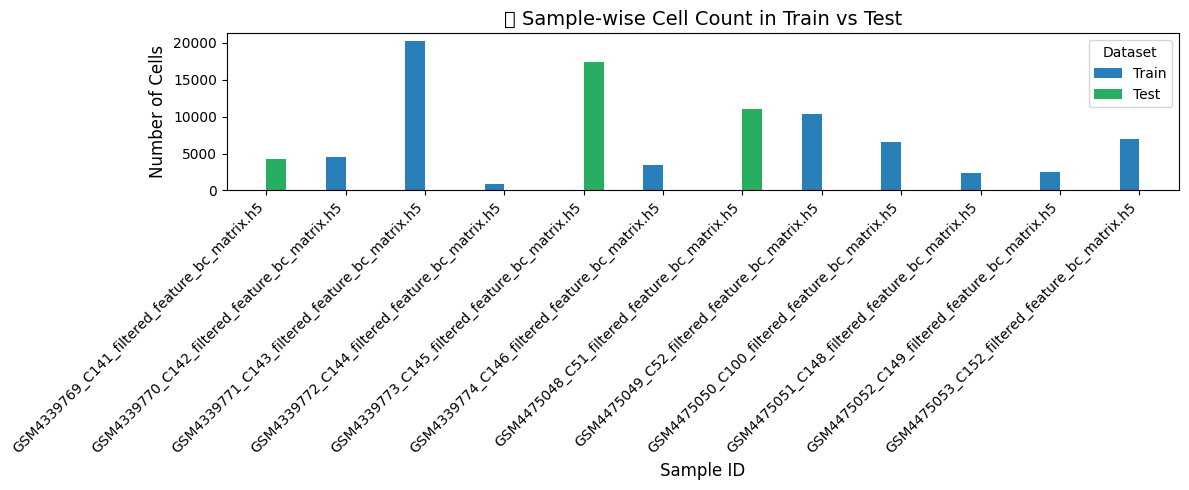

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Recreate sample distribution counts
train_counts = adata_train.obs['sample_id'].value_counts()
test_counts = adata_test.obs['sample_id'].value_counts()

# Combine into a DataFrame
sample_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

# Create the plot
plt.figure(figsize=(12, 6))
ax = sample_df.plot(kind='bar', figsize=(12, 5), color=['#2980b9', '#27ae60'])

# Improve X-axis label readability
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better visibility
plt.xlabel("Sample ID", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.title("📊 Sample-wise Cell Count in Train vs Test", fontsize=14)

# Improve legend placement
plt.legend(title="Dataset", fontsize=10, loc="upper right")

plt.tight_layout()
plt.show()


# PCA 


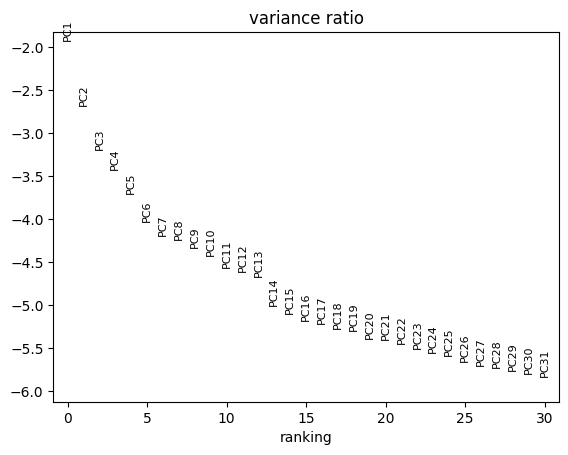

In [ ]:
# Run PCA on TRAIN set
sc.tl.pca(adata_train, svd_solver='arpack', n_comps=200)

# Plot variance explained by each Principal Component (PC)
sc.pl.pca_variance_ratio(adata_train, log=True)


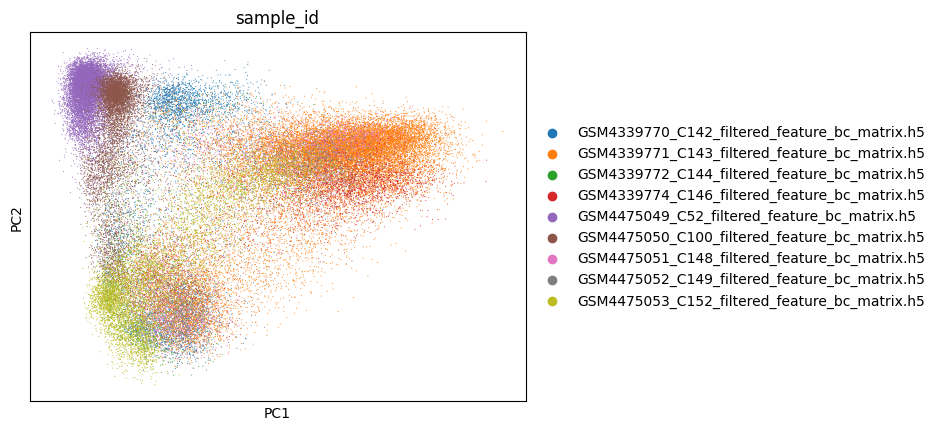

In [24]:
sc.pl.pca(adata_train, color=['sample_id'])  # Replace 'sample_id' with labels if available


In [ ]:
# Apply PCA transformation to TEST set
sc.tl.pca(adata_test, svd_solver='arpack', n_comps=200)


In [26]:
import pandas as pd

# Extract PCA coordinates
pca_train = adata_train.obsm['X_pca']
pca_test = adata_test.obsm['X_pca']

# Convert to DataFrame
df_pca_train = pd.DataFrame(pca_train, index=adata_train.obs.index)
df_pca_test = pd.DataFrame(pca_test, index=adata_test.obs.index)

# Save as CSV for later use
df_pca_train.to_csv("pca_train.csv")
df_pca_test.to_csv("pca_test.csv")

print("✅ PCA embeddings saved successfully!")


✅ PCA embeddings saved successfully!


# UMAP/T-SNE

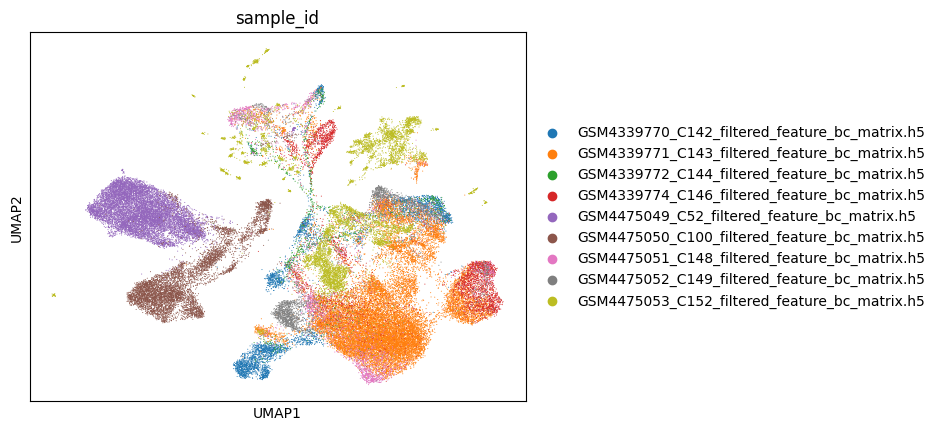

In [27]:
# Compute UMAP on Train Set
sc.pp.neighbors(adata_train, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_train)

# Plot UMAP for train
sc.pl.umap(adata_train, color=['sample_id'])  # Can replace with label if needed


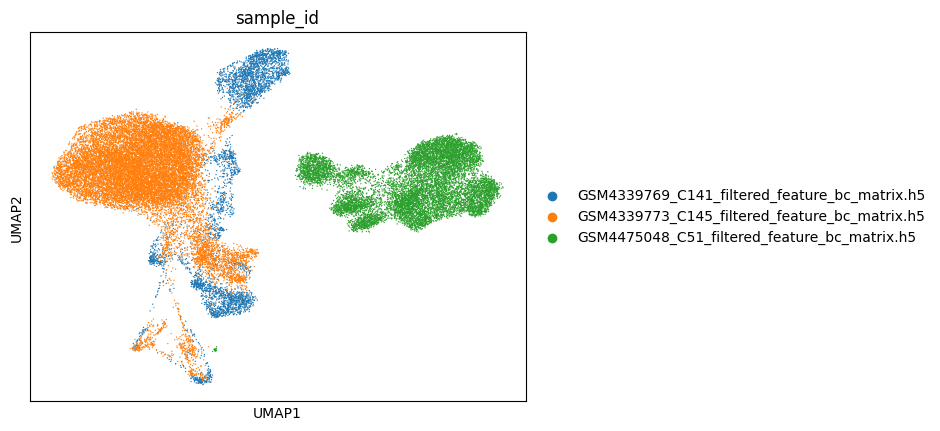

In [28]:

# Compute UMAP on Test Set (Using train-set parameters)
sc.pp.neighbors(adata_test, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_test)

# Plot UMAP for test
sc.pl.umap(adata_test, color=['sample_id'])


# SVM

In [29]:
print("Available columns in adata_train.obs:", adata_train.obs.columns)
print("Available columns in adata_test.obs:", adata_test.obs.columns)


Available columns in adata_train.obs: Index(['sample_id', 'sample_batch', 'n_genes', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'],
      dtype='object')
Available columns in adata_test.obs: Index(['sample_id', 'sample_batch', 'n_genes', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'],
      dtype='object')


In [30]:
# Define sample-to-label mapping (from your previous message)
sample_to_label = {
    "GSM4339769": "mild",
    "GSM4339770": "mild",
    "GSM4339771": "severe",
    "GSM4339772": "mild",
    "GSM4339773": "severe",
    "GSM4339774": "severe",
    "GSM4475048": "healthy",
    "GSM4475049": "healthy",
    "GSM4475050": "healthy",
    "GSM4475051": "severe",
    "GSM4475052": "severe",
    "GSM4475053": "severe",
}

# Attach labels to individual cells based on their sample_id
adata_train.obs['label'] = adata_train.obs['sample_id'].map(lambda x: sample_to_label.get(x.split("_")[0], "unknown"))
adata_test.obs['label'] = adata_test.obs['sample_id'].map(lambda x: sample_to_label.get(x.split("_")[0], "unknown"))

# Verify if labels were correctly assigned
print("Train set label distribution:\n", adata_train.obs['label'].value_counts())
print("Test set label distribution:\n", adata_test.obs['label'].value_counts())


Train set label distribution:
 label
severe     35533
healthy    16944
mild        5477
Name: count, dtype: int64
Test set label distribution:
 label
severe     17396
healthy    11112
mild        4233
Name: count, dtype: int64


## CELL LEVEL

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load PCA embeddings
X_train = pd.read_csv("pca_train.csv", index_col=0)
X_test = pd.read_csv("pca_test.csv", index_col=0)

# Load assigned labels
y_train = adata_train.obs['label']
y_test = adata_test.obs['label']

# Train SVM model
clf = SVC(kernel='rbf', probability=True, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
print(f"✅ Cell-Level SVM Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Save predictions
df_preds = pd.DataFrame({'true_label': y_test, 'predicted_label': y_pred}, index=X_test.index)
df_preds.to_csv("cell_level_predictions.csv")

print("📁 Saved cell-level predictions to 'cell_level_predictions.csv'")








✅ Cell-Level SVM Accuracy: 0.85
              precision    recall  f1-score   support

     healthy       0.99      0.94      0.97     11112
        mild       0.07      0.01      0.02      4233
      severe       0.79      0.99      0.88     17396

    accuracy                           0.85     32741
   macro avg       0.62      0.65      0.62     32741
weighted avg       0.77      0.85      0.80     32741

📁 Saved cell-level predictions to 'cell_level_predictions.csv'


## PATIENT LEVEL 

In [35]:
import pandas as pd

# Load cell-level predictions (as previously saved)
df_preds = pd.read_csv("cell_level_predictions.csv", index_col=0)

# Create a temporary copy of adata_test.obs with only the necessary columns
# (sample_id and label), and drop duplicate cell IDs (keeping the first)
temp_obs = adata_test.obs[['sample_id', 'label']].copy()
temp_obs = temp_obs[~temp_obs.index.duplicated(keep='first')]

# Map each cell (index) in df_preds to its sample_id using temp_obs;
# if a cell id is not found, assign None.
df_preds['sample_id'] = df_preds.index.map(lambda x: temp_obs.loc[x, 'sample_id'] if x in temp_obs.index else None)

# Perform majority voting: for each sample, take the mode of the predicted_label.
patient_preds = df_preds.groupby("sample_id")["predicted_label"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)

# Get true patient-level labels by grouping temp_obs by sample_id
true_patient_labels = temp_obs.groupby("sample_id")["label"].first()

# Reindex patient_preds to match true_patient_labels and compute accuracy.
patient_preds = patient_preds.reindex(true_patient_labels.index)
accuracy = (patient_preds == true_patient_labels).mean()
print(f"\n🏥 Patient-Level Accuracy: {accuracy:.2f}")

# Save patient-level predictions to CSV
patient_df = pd.DataFrame({
    "true_label": true_patient_labels,
    "predicted_label": patient_preds
})
patient_df.to_csv("patient_level_predictions.csv")

print("📁 Saved patient-level predictions to 'patient_level_predictions.csv'")



🏥 Patient-Level Accuracy: 0.67
📁 Saved patient-level predictions to 'patient_level_predictions.csv'


## BIOMARKER IDENTIFICATION

In [33]:
# !pip install shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Use X_train (PCA embeddings DataFrame) loaded earlier
# Sample a subset of background data for KernelExplainer (adjust number as needed)
background = X_train.sample(100, random_state=42)

# Also sample some cells to explain (e.g., 50 cells)
X_explain = X_train.sample(50, random_state=42)

# Define a prediction function that returns probability predictions from your SVM
def model_predict(data):
    return clf.predict_proba(data)

# Create a KernelExplainer using the SVM prediction function and background data
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values for the sampled data. 
# Since SVM is multi-class, shap_values will be a list with one array per class.
shap_values = explainer.shap_values(X_explain)

# For each class, produce a SHAP summary plot.
for i, class_name in enumerate(clf.classes_):
    # The summary plot shows the impact of each feature on the model's output for this class.
    shap.summary_plot(
        shap_values[i], 
        X_explain, 
        feature_names=X_explain.columns,
        plot_size=(10,6),
        title=f"SHAP Summary for Class: {class_name}",
        show=True
    )


 12%|█▏        | 6/50 [20:19<2:28:45, 202.86s/it]